<a href="https://colab.research.google.com/github/yamilart/DataLabs/blob/main/Without_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐾 Who let the dogs out? 🐾

Final Project: Dog breed detection

A little info:

*   The original [dataset](https://www.kaggle.com/c/dog-breed-identification/overview) consist in 2 folders with over 20000 images of dogs and a csv with 120 breeds. 
*   I edited the dataset a bit (since there where no dachshunds and dachshunds = 💗) and also only worked with the images in the "train" folder
*   This is the 'full' model with 20 breeds, the short version using 10 breeds was made directly on Jupyter notebook and it's called 'Who let 'some' dogs out?'

## Packages

In [ ]:
import os
import cv2
import pickle
import datetime
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Input, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, load_model, Model
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from IPython.display import display, Image  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from matplotlib.pyplot import imread
import PIL.Image
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from google.colab import drive
from google.colab.patches import cv2_imshow

## Getting Data & EDA

In [ ]:
# loading & checking data: breeds
drive.mount('/content/drive') # this is to open files from my drive

Mounted at /content/drive


In [ ]:
# loading & checking data: breeds
dogbreeds = pd.read_csv('/content/drive/MyDrive/dog-breeds/labelsbreeds.csv') 
# personal note: paths are going to be different on my computer
dogbreeds

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [ ]:
dogbreeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [ ]:
dogbreeds['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

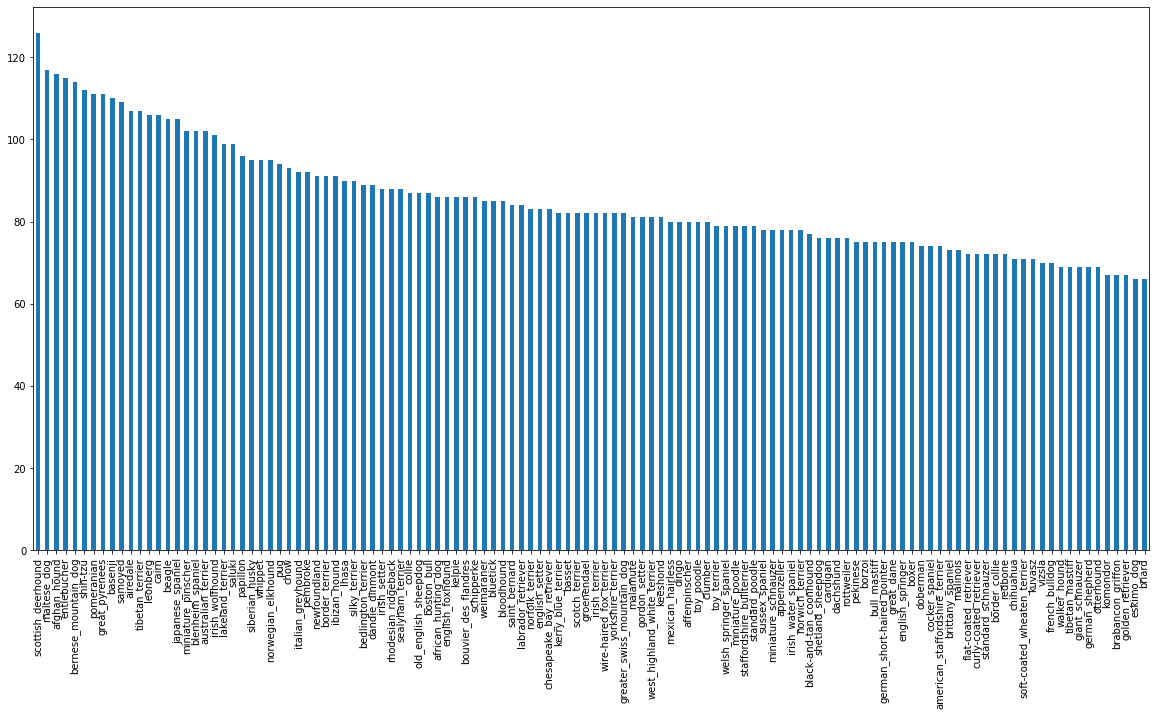

In [ ]:
# visualizing the amount of pictures of each breed
dogbreeds['breed'].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
# checking the breeds
dogbreeds['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dachshund', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'b

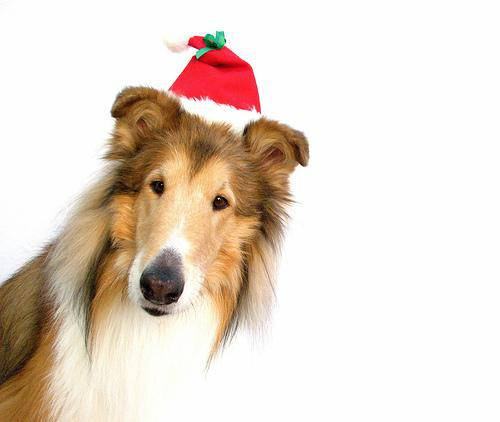

In [ ]:
# naming the picture folder
images = '/content/drive/MyDrive/dog-breeds/trainbreeds/'
# checking a random picture
Image('/content/drive/MyDrive/dog-breeds/trainbreeds/0a6c192b96e55e2ca37318919b1ffae6.jpg')

A festive cutie!

In [ ]:
# now i need to get the image path in the csv file
dogs = dogbreeds.copy()
dogs['image_path'] = dogbreeds['id'].apply(lambda x: x + ".jpg")
dogs

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,ffd25009d635cfd16e793503ac5edef0.jpg
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,ffe5f6d8e2bff356e9482a80a6e29aac.jpg


In [ ]:
# got to make sure I don't have any nulls there since I edited the original data
dogs.isna().sum()

id            0
breed         0
image_path    0
dtype: int64

In [ ]:
# checking if it works, if I call the id of the picture before I shold get a... border collie?
dogs.loc[dogbreeds['id'] == '0a6c192b96e55e2ca37318919b1ffae6']

,id,breed,image_path
434,0a6c192b96e55e2ca37318919b1ffae6,collie,0a6c192b96e55e2ca37318919b1ffae6.jpg


Collie & Border Collie are different breeds apparently! The more you learn...

In [ ]:
# checking one more because: dogs
dogs['breed'][42]

'dachshund'

In [ ]:
# locating the id to find the picture
dogs.iloc[42]

id                011e06760794850c40f23d6426c40774
breed                                    dachshund
image_path    011e06760794850c40f23d6426c40774.jpg
Name: 42, dtype: object

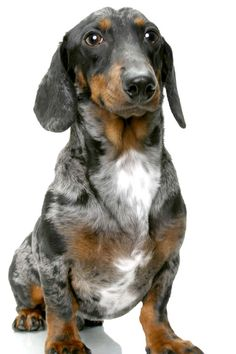

In [ ]:
Image('/content/drive/MyDrive/dog-breeds/trainbreeds/011e06760794850c40f23d6426c40774.jpg')

Oh god, so cute

In [ ]:
# making a copy of the data just in case
somedogs = dogs.copy()

## Selecting data

Since 120 breeds is **A LOT OF DATA TO WORK WITH** I'm going to be realistic and will choose only 20 breeds to start.  
The selection is based on breeds I can recognize and also look quite different to see if this helps the model (or not)

In [ ]:
# breed selection: 
breedselection = ['dachshund', 'golden_retriever', 'chow', 'siberian_husky', 
                                                'great_dane', 'french_bulldog', 'rottweiler', 'cocker_spaniel', 
                                                'pekinese', 'doberman', 'boxer', 'labrador_retriever', 
                                                'samoyed', 'beagle', 'chihuahua', 'toy_terrier', 
                                                'weimaraner', 'collie', 'bloodhound', 'yorkshire_terrier']
somedogs = somedogs.loc[somedogs['breed'].isin(breedselection)]
somedogs.reset_index(drop = True, inplace = True)
somedogs.head()

,id,breed,image_path
0,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
1,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg
2,008887054b18ba3c7601792b6a453cc3,boxer,008887054b18ba3c7601792b6a453cc3.jpg
3,008b1271ed1addaccf93783b39deab45,doberman,008b1271ed1addaccf93783b39deab45.jpg
4,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever,00a366d4b4a9bbb6c8a63126697b7656.jpg


In [ ]:
somedogs['breed'].value_counts()

samoyed               109
beagle                105
siberian_husky         95
chow                   93
collie                 87
weimaraner             85
bloodhound             85
labrador_retriever     84
yorkshire_terrier      82
toy_terrier            79
dachshund              76
rottweiler             76
pekinese               75
boxer                  75
great_dane             75
doberman               74
cocker_spaniel         74
chihuahua              71
french_bulldog         70
golden_retriever       67
Name: breed, dtype: int64

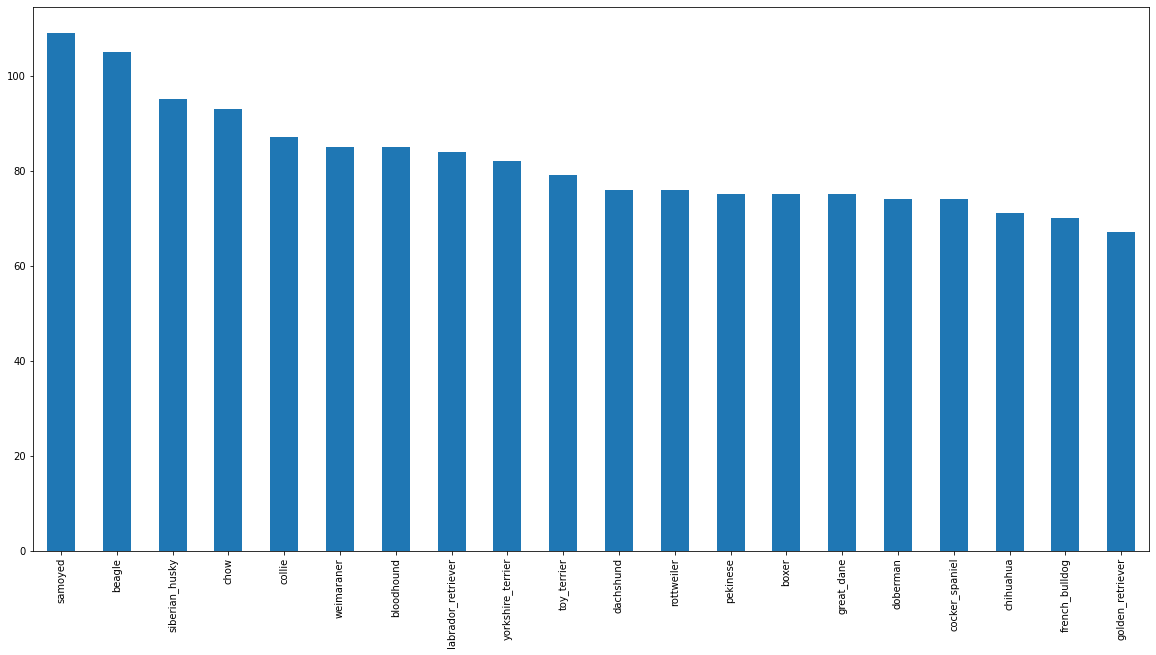

In [ ]:
# the amount of pictures of each breed: the graph way
somedogs['breed'].value_counts().plot.bar(figsize=(20, 10));

## Transforming data
I need to transform the data in order to work with it since I basically have images and a bunch of texts.

### Breeds
First I'm turning the breeds into arrays
 

In [ ]:
# converting breed names into numericals, using labelencoder
lencoder = LabelEncoder()

breeds = lencoder.fit_transform(somedogs['breed'])

breedarray = to_categorical(breeds)
breedarray

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Images
I need to resize my images (going to use 224 x 224), add a color layer (RGB: 3), turn the images into arrays and scale that array from -1 to 1.
So I'm basically turning my images into Tensors to be able to use them with TensorFlow.

In [ ]:
# np.zeros gives me an array of... you guessed it! zeroes
# np.zeros(amount of values, image size, image size, rgb layer)
tensorimages = np.zeros((len(somedogs), 224, 224, 3), dtype='float32')
 
# now the for loop:
for i, image in enumerate(somedogs['image_path']):
# this part reads the image, resizes it, adds the color layer and converts it to an array, for free!
    img = cv2.resize(cv2.imread(images + image, cv2.IMREAD_COLOR),((224, 224)))
# this part scales the array from -1 to 1 and expands it on the 0 axis, apparently
    img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
# and now I add the new creation into the array made of zeroes
    tensorimages[i] = img_array

### Variables X & y

In [ ]:
# Find the unique label values
#unique_breeds = np.unique(somedogs['breed'])
#len(unique_breeds)
#boolean_labels = [label == unique_breeds for label in somedogs['breed']]

In [ ]:
#X_data = np.zeros((len(labels), 224, 224 ,3), dtype='float32')
#Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

#for i in tqdm(range(len(labels))):
#  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size = (224, 224))
#  img = image.img_to_array(img)
#  x = np.expand_dims(img.copy(), axis = 0)
#  X_data[i] = x/255.0

#print('\nTrain Images shape: ', X_data.shape, ' size: {:,}'.format(X_data.size))
#print('one-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

X = tensorimages
#y = label_binarize(somedogs['breed'], classes = breedselection)
y = breedarray
X.shape

(1637, 224, 224, 3)

In [ ]:
y.shape

(1637, 20)

In [ ]:
#X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.3, random_state = 42)


# split the dataset: 70% for training and 30% for testing. Randomness at 42 because it's the answer
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# checking if lengths are equal
#print(len(X_train), len(y_train), len(X_test), len(y_test))

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.7)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1145, 224, 224, 3)
(1145, 20)
(246, 224, 224, 3)
(246, 20)
(246, 224, 224, 3)
(246, 20)


(None, None)

## Models
I'll be working with the Keras [Sequencial model](https://keras.io/guides/sequential_model/) only, trying different values and layers.   
Since it's a linear stack of layers it's was easier for me to understand it and apply it knowing what I was doing.

Initially I had planned to apply also a Functional Model bulding a ResNet but I really couldn't understand the process and my loss values where off the roof.   
It's going into my Wishlist.


**Defining first steps**

In [ ]:
# Setup input shape to the model = batch, height, width, colour channels
in_shape = [None, 224, 224, 3] 

# Setup output shape of the model = amount of unique breeds
out_shape = len(somedogs['breed'].unique())

# Create early stopping (once the model stops improving, stop training) Patience is the number of improvements
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 4)

# How many rounds should we get the model to look through the data?
num_epochs = 25

# Setup model URLs from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

### First Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dense(out_shape, activation = 'softmax'))
model.build(in_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 300)               45158700  
                                                                 
 dense_5 (Dense)             (None, 100)               30100     
                                                                 
 dense_6 (Dense)             (None, 20)                2020      
                                                                 
Total params: 45,190,820
Trainable params: 45,190,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
              )

history = model.fit(X_train, y_train,
          epochs = num_epochs,
          validation_data = (X_valid, y_valid),
          validation_freq = 1, # check validation metrics every epoch
          callbacks = early_stopping)

Epoch 1/25
36/36 [==============================] - 13s 340ms/step - loss: 33.7278 - accuracy: 0.0646 - val_loss: 16.8195 - val_accuracy: 0.0894
Epoch 2/25
36/36 [==============================] - 11s 306ms/step - loss: 7.2988 - accuracy: 0.1493 - val_loss: 5.3359 - val_accuracy: 0.0772
Epoch 3/25
36/36 [==============================] - 11s 316ms/step - loss: 2.9378 - accuracy: 0.1782 - val_loss: 4.1320 - val_accuracy: 0.0407
Epoch 4/25
36/36 [==============================] - 12s 336ms/step - loss: 2.5358 - accuracy: 0.2131 - val_loss: 4.2193 - val_accuracy: 0.0650
Epoch 5/25
36/36 [==============================] - 12s 341ms/step - loss: 2.3448 - accuracy: 0.2533 - val_loss: 4.4968 - val_accuracy: 0.0528


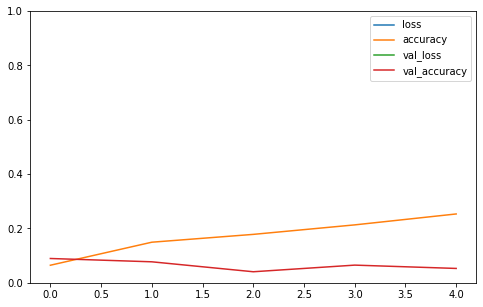

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8,5))
pyplot.grid = (True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

A lame first attempt, but hey, it was my first Model! *#proud*

### Second Model

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(hub.KerasLayer(model_url))
model2.add(keras.layers.Dense(out_shape, activation = 'softmax'))
model2.build(in_shape)
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_7 (Dense)             (None, 20)                20040     
                                                                 
Total params: 5,452,753
Trainable params: 20,040
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
model2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
              )

history2 = model2.fit(X_train, y_train,
          epochs = num_epochs,
          validation_data = (X_valid, y_valid),
          validation_freq = 1, # check validation metrics every epoch
          callbacks = early_stopping)

Epoch 1/25
36/36 [==============================] - 57s 1s/step - loss: 2.7835 - accuracy: 0.2576 - val_loss: 1.7926 - val_accuracy: 0.4675
Epoch 2/25
36/36 [==============================] - 52s 1s/step - loss: 1.2396 - accuracy: 0.6306 - val_loss: 1.3673 - val_accuracy: 0.5691
Epoch 3/25
36/36 [==============================] - 52s 1s/step - loss: 0.8417 - accuracy: 0.7555 - val_loss: 1.2472 - val_accuracy: 0.6179
Epoch 4/25
36/36 [==============================] - 52s 1s/step - loss: 0.6215 - accuracy: 0.8332 - val_loss: 1.1723 - val_accuracy: 0.6382
Epoch 5/25
36/36 [==============================] - 52s 1s/step - loss: 0.4914 - accuracy: 0.8716 - val_loss: 1.1755 - val_accuracy: 0.6463
Epoch 6/25
36/36 [==============================] - 52s 1s/step - loss: 0.3958 - accuracy: 0.9066 - val_loss: 1.1588 - val_accuracy: 0.6545
Epoch 7/25
36/36 [==============================] - 52s 1s/step - loss: 0.3179 - accuracy: 0.9450 - val_loss: 1.1485 - val_accuracy: 0.6463
Epoch 8/25
36/36 [==

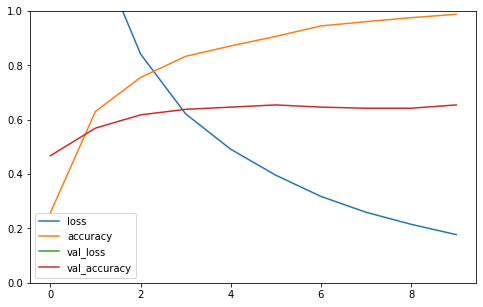

In [ ]:
pd.DataFrame(history2.history).plot(figsize = (8,5))
pyplot.grid = (True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

Accuracy is at 80%! But the validation accuracy is only 57%

### Third Model

In [ ]:
model3 = tf.keras.models.Sequential()
model3.add(keras.layers.Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model3.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(500, activation = 'relu'))
model3.add(keras.layers.Dense(250, activation = 'relu'))
model3.add(keras.layers.Dense(out_shape, activation = 'softmax'))
model3.build(in_shape)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 500)               75264500  
                                                                 
 dense_5 (Dense)             (None, 250)               125250    
                                                                 
 dense_6 (Dense)             (None, 20)                5020      
                                                                 
Total params: 75,394,770
Trainable params: 75,394,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"]
              )

history3 = model3.fit(X_train, y_train,
          epochs = num_epochs,
          validation_data = (X_valid, y_valid),
          validation_freq = 1, # check validation metrics every epoch
          callbacks = early_stopping)

Epoch 1/25
36/36 [==============================] - 18s 503ms/step - loss: 45.2178 - accuracy: 0.0533 - val_loss: 26.8227 - val_accuracy: 0.0671
Epoch 2/25
36/36 [==============================] - 17s 487ms/step - loss: 14.9562 - accuracy: 0.0550 - val_loss: 4.5085 - val_accuracy: 0.0528
Epoch 3/25
36/36 [==============================] - 18s 496ms/step - loss: 3.5421 - accuracy: 0.0559 - val_loss: 3.2687 - val_accuracy: 0.0447
Epoch 4/25
36/36 [==============================] - 18s 495ms/step - loss: 3.1107 - accuracy: 0.0725 - val_loss: 3.2077 - val_accuracy: 0.0508
Epoch 5/25
36/36 [==============================] - 18s 489ms/step - loss: 3.0481 - accuracy: 0.0742 - val_loss: 3.1492 - val_accuracy: 0.0528


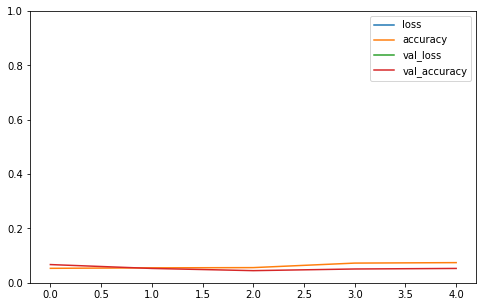

In [ ]:
pd.DataFrame(history3.history).plot(figsize = (8,5))
pyplot.grid = (True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

### Fourth model

In [ ]:
# Importing ResNet50 from Keras
from tensorflow.keras.applications.resnet50 import ResNet50
# load model
model4 = tf.keras.models.Sequential()
# Adding Resnet50 with pretrained imagenet weights
model4.add(ResNet50(weights="imagenet", pooling=max, include_top = False, input_shape= (224, 224, 3)))
# 2nd layer as Dense for classification
model4.add(keras.layers.GlobalAveragePooling2D())
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Dense(out_shape, activation = 'softmax'))
# Not training firstlayer 
model4.layers[0].trainable = False
model4.build(in_shape)
model4.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 20)                40980     
                                                                 
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


### Quick check

In [ ]:
y_pred = model2.predict(X_test)
score = model2.evaluate(X_test, y_test)
print('Accuracy on test: ', round((score[1]*100), 2), '%')

8/8 [==============================] - 9s 1s/step - loss: 1.3447 - accuracy: 0.6667
Accuracy over the test set: 
  66.67 %


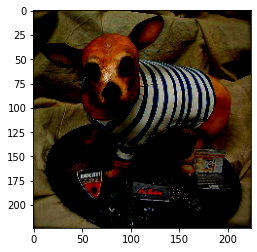

In [ ]:
# trying an image
plt.imshow(X_test[1,:,:,:])
plt.show()

In [ ]:
# checking the breeds
print("Originally : ",somedogs['breed'][np.argmax(y_test[1])])
print("Predicted : ",somedogs['breed'][np.argmax(y_pred[1])])

Originally :  doberman
Predicted :  golden_retriever


Something is wrong :(

### Saving the best model

In [ ]:
def save_model(model, suffix=None):
  modeldir = os.path.join("/content/drive/My Drive/dog-breeds/")
  model_path = modeldir + "-" + suffix + ".h5" 
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
#Save the best model for prediction
save_model(model2, suffix="20-breeds")

'/content/drive/My Drive/dog-breeds/-20-breeds.h5'

In [ ]:
somebreeds[id]

### Trying the best model

Trying the best model using a picture of my dog: Ozzy

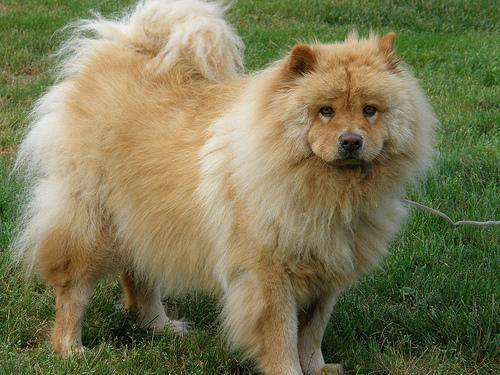

In [ ]:
Image('/content/drive/MyDrive/dog-breeds/trainbreeds/0c207c7af2d1ef71dc61434f04d00cdf.jpg')

In [ ]:
def breed_predictor(image_file):
    image = cv2.imread(image_file)
    image = cv2.resize(image, (224, 224))
    # dog_img = Image.open(image_file)
    image = image.reshape(1,224,224,3)
    result_prob = model2.predict(image)
    result = result_prob.argmax(axis=-1)
    result = lencoder.inverse_transform(result)
    return f'Predicted Breed: {result[0]} with probability of {round(np.amax(result_prob)*100,2)}%,'
file_n = '/content/drive/MyDrive/dog-breeds/trainbreeds/0c207c7af2d1ef71dc61434f04d00cdf.jpg'
breed_predictor(file_n)

'Predicted Breed: cocker_spaniel with probability of 37.79%,'

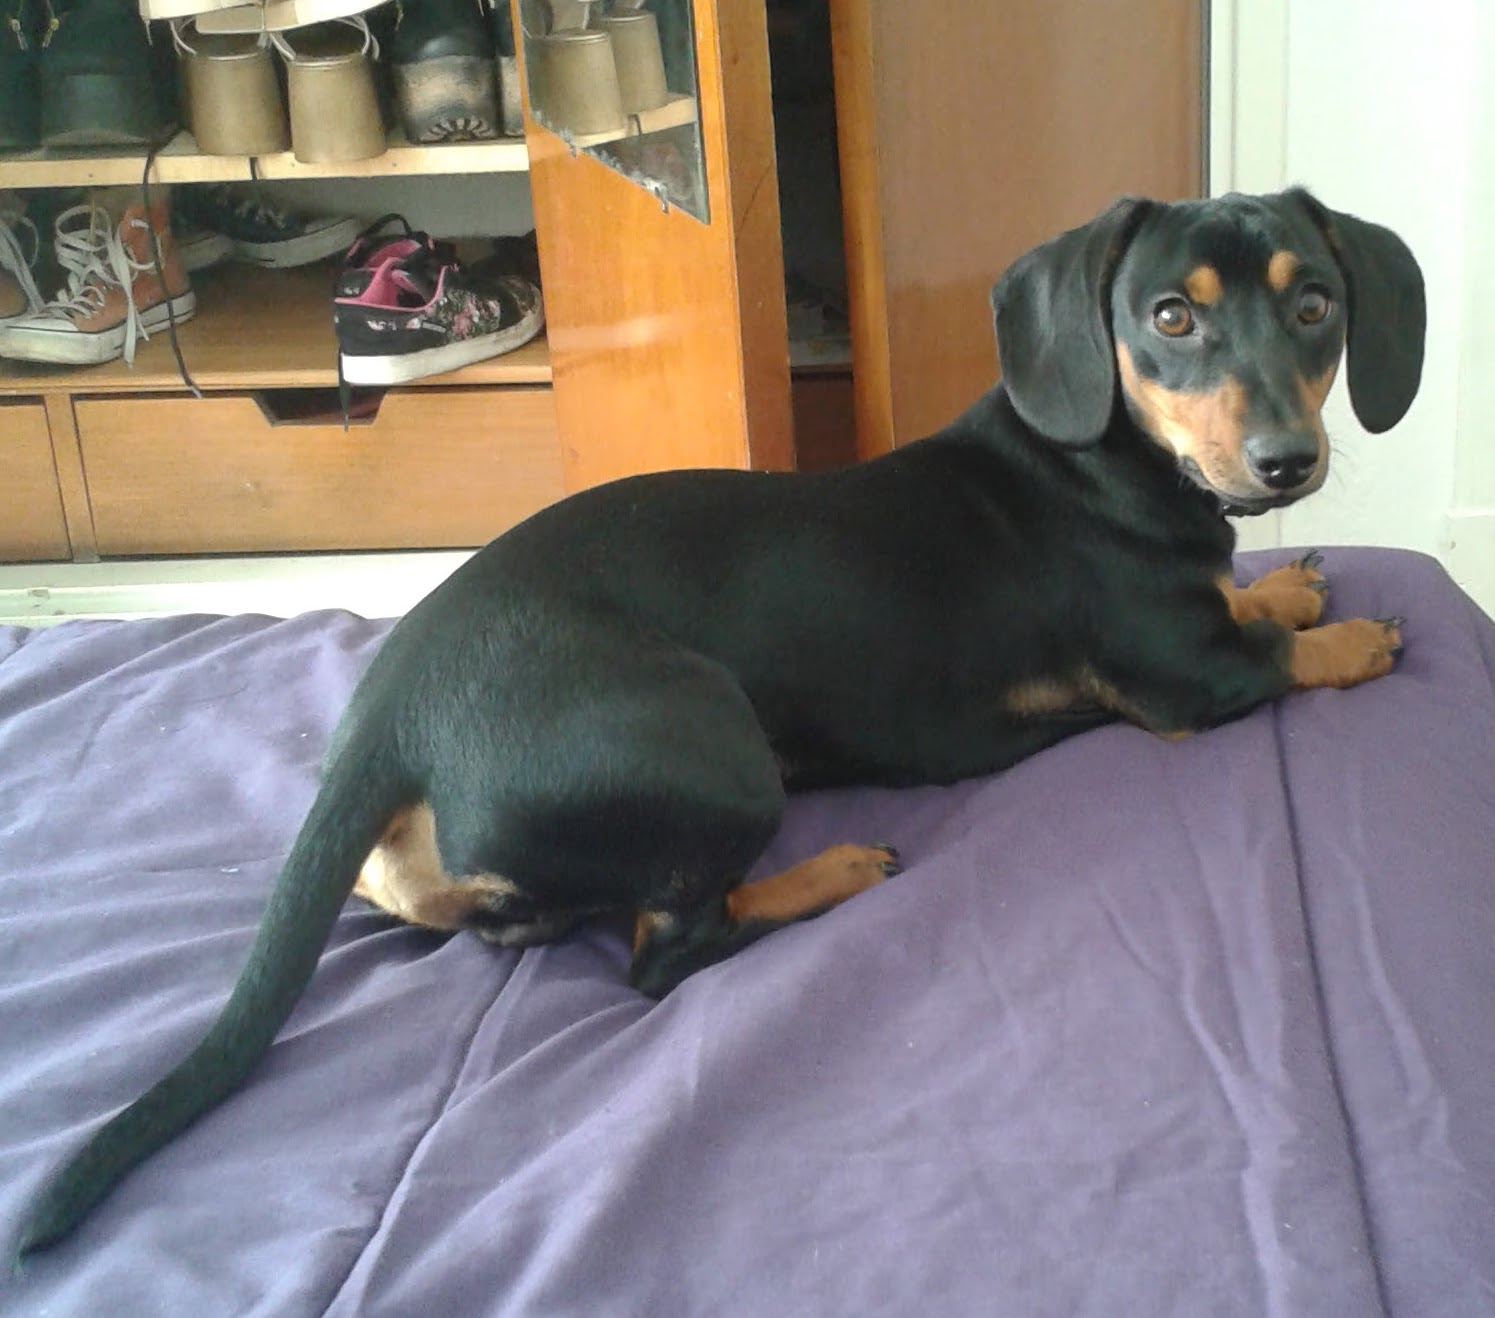

In [ ]:
Image('/content/drive/MyDrive/dog-breeds/ozzy.jpg')

In [ ]:
#load the model
model = load_model('/content/drive/My Drive/dog-breeds/-20-breeds.h5')
 
#get the image of the dog for prediction
dog_img_path = '/content/drive/MyDrive/dog-breeds/ozzy.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
dog_img_array = cv2.resize(cv2.imread(dog_img_path, cv2.IMREAD_COLOR), ((224,224)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
dog_img_array = preprocess_input(np.expand_dims(np.array(dog_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(dog_img_array, dtype="float32"))
 
#display the image of dog
#cv2.imshow(cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR),((224,224)))) 
Image(cv2.resize(cv2.imread(dog_img_path, cv2.IMREAD_COLOR), ((224,224)))) 
 
#display the predicted breed of dog
pred_breed = sorted(somedogs['breed'])[np.argmax(pred_val)]
print("This cutie is a: ", pred_breed)

This cutie is a:  beagle


In [ ]:
model = load_model('/content/drive/My Drive/dog-breeds/-20-breeds.h5')
 
#get the image of the dog for prediction
dog_img_path = '/content/drive/MyDrive/dog-breeds/dachshund.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
dog_img_array = cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR), ((224,224)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
dog_img_array = preprocess_input(np.expand_dims(np.array(dog_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(dog_img_array, dtype = "float32"))
 
#display the image of dog
#cv2.imshow(cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR),((224,224)))) 
Image(cv2.resize(cv2.imread(dog_img_path, cv2.IMREAD_COLOR), ((224,224)))) 
 
#display the predicted breed of dog
pred_breed = sorted(somedogs['breed'])[np.argmax(pred_val)]
print("This cutie is a: ", pred_breed)

This cutie is a:  beagle


In [ ]:
model = load_model('/content/drive/My Drive/dog-breeds/-20-breeds.h5')
 
#get the image of the dog for prediction
dog_img_path = '/content/drive/MyDrive/dog-breeds/samoyed.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
dog_img_array = cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR), ((224,224)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
dog_img_array = preprocess_input(np.expand_dims(np.array(dog_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(dog_img_array, dtype = "float32"))
 
#display the image of dog
#cv2.imshow(cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR),((224,224)))) 
Image(cv2.resize(cv2.imread(dog_img_path, cv2.IMREAD_COLOR), ((224,224)))) 
 
#display the predicted breed of dog
pred_breed = sorted(somedogs['breed'])[np.argmax(pred_val)]
print("This cutie is a: ", pred_breed)

This cutie is a:  boxer


In [ ]:
model = load_model('/content/drive/My Drive/dog-breeds/-20-breeds.h5')
 
#get the image of the dog for prediction
dog_img_path = '/content/drive/MyDrive/dog-breeds/trainbreeds/001cdf01b096e06d78e9e5112d419397.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
dog_img_array = cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR), ((224,224)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
dog_img_array = preprocess_input(np.expand_dims(np.array(dog_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(dog_img_array, dtype = "float32"))
 
#display the image of dog
#cv2.imshow(cv2.resize(cv2.imread(dog_img_path,cv2.IMREAD_COLOR),((224,224)))) 
Image(cv2.resize(cv2.imread(dog_img_path, cv2.IMREAD_COLOR), ((224,224)))) 
 
#display the predicted breed of dog
pred_breed = sorted(somedogs['breed'])[np.argmax(pred_val)]
print("This cutie is a: ", pred_breed)

This cutie is a:  beagle
